<a href="https://colab.research.google.com/github/Antonsen2/wildfire-ai/blob/research/neural-networks/optimize_model_architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00


In [4]:
import keras_tuner
import os.path
import itertools
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow import keras
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-01-16 07:27:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-16 07:27:53 (83.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Load dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
DATA_PATH = '/content/drive/MyDrive/full'
IMG_DIR = Path(DATA_PATH)

In [8]:
walk_through_dir(DATA_PATH)

There are 3 directories and 0 images in '/content/drive/MyDrive/full'.
There are 0 directories and 2071 images in '/content/drive/MyDrive/full/fire'.
There are 0 directories and 2150 images in '/content/drive/MyDrive/full/satellite'.
There are 0 directories and 500 images in '/content/drive/MyDrive/full/nonfire'.


## Prepare Dataset

In [9]:
def split_df(df: pd.DataFrame, cols: list, **kwargs) -> pd.DataFrame:
    df1 = pd.DataFrame()

    for k, v in kwargs.items():
        df2 = df.loc[df['Label'] == k][cols].sample(n=v)
        df1 = pd.concat([df1, df2])

    df1.index = range(len(df1))
    return df1

In [10]:
filepaths = list(IMG_DIR.glob(r'**/*.JPG')) + list(IMG_DIR.glob(r'**/*.jpg')) + list(IMG_DIR.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,/content/drive/MyDrive/full/fire/fire-837.jpg,fire
1,/content/drive/MyDrive/full/fire/fire-1095.jpg,fire
2,/content/drive/MyDrive/full/fire/fire-759.jpg,fire
3,/content/drive/MyDrive/full/fire/fire-1047.jpg,fire
4,/content/drive/MyDrive/full/fire/fire-821.jpg,fire
...,...,...
4716,/content/drive/MyDrive/full/nonfire/forest-396...,nonfire
4717,/content/drive/MyDrive/full/nonfire/forest-401...,nonfire
4718,/content/drive/MyDrive/full/nonfire/forest-381...,nonfire
4719,/content/drive/MyDrive/full/nonfire/forest-458...,nonfire


In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
df_full = split_df(
    df=image_df.copy(),
    cols=['Filepath', 'Label'],
    fire=2071,
    nonfire=500
)

In [13]:
train_df, test_df = train_test_split(
    df_full, test_size=0.2, shuffle=True, random_state=42
)

In [14]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
RANDOM_SEED = 42

In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1645 validated image filenames belonging to 2 classes.
Found 411 validated image filenames belonging to 2 classes.
Found 515 validated image filenames belonging to 2 classes.


# Frist training

In [26]:
checkpoint_path = "fires_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [29]:
    pretrained_model = MobileNetV2(
      input_shape=IMG_SIZE+ (3,),
      include_top=False,
      weights='imagenet',
      pooling='avg')

In [30]:
def train_model(pretrained_model: MobileNetV2, train_images, val_images) -> tuple:
    resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(*IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),])

    pretrained_model = MobileNetV2(
    input_shape=IMG_SIZE+ (3,),
    include_top=False,
    weights='imagenet',
    pooling='avg')
    
    inputs = pretrained_model.input
    X = resize_and_rescale(inputs)

    X = Dense(256, activation='relu')(pretrained_model.output)
    X = Dropout(0.2)(X)
    X = Dense(256, activation='relu')(X)
    X = Dropout(0.2)(X)


    outputs = Dense(2, activation='softmax')(X)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=100,
        callbacks=[
            early_stopping,
            create_tensorboard_callback(
                'training_logs', 
                'fire_classification'
            ),
            checkpoint_callback,
        ]
    )

    return model, history

In [31]:
model, history = train_model(pretrained_model, train_images, val_images)

Saving TensorBoard log files to: training_logs/fire_classification/20230116-081237
Epoch 1/100
52/52 [==============================] - 19s 259ms/step - loss: 0.1633 - accuracy: 0.9313 - val_loss: 0.0690 - val_accuracy: 0.9805
Epoch 2/100
52/52 [==============================] - 12s 230ms/step - loss: 0.0085 - accuracy: 0.9976 - val_loss: 0.1249 - val_accuracy: 0.9611
Epoch 3/100
52/52 [==============================] - 12s 225ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.1120 - val_accuracy: 0.9684
Epoch 4/100
52/52 [==============================] - 12s 235ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0139 - val_accuracy: 0.9951
Epoch 5/100
52/52 [==============================] - 12s 234ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.0609 - val_accuracy: 0.9708
Epoch 6/100
52/52 [==============================] - 12s 235ms/step - loss: 0.0085 - accuracy: 0.9982 - val_loss: 0.0102 - val_accuracy: 0.9951
Epoch 7/100
52/52 [==============================] - 

## Check overfitting

In [38]:
def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy') 
  plt.figure()

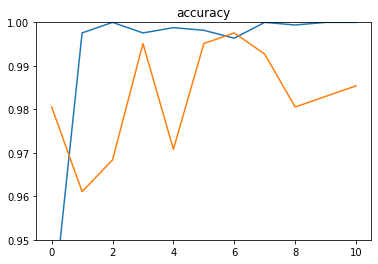

<Figure size 432x288 with 0 Axes>

In [39]:
plot_accuracy(history, miny=0.95)

# Model Optimization

In [19]:
def build_model(hp):
    resize_and_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(*IMG_SIZE),
      layers.experimental.preprocessing.Rescaling(1./255),])

    pretrained_model = MobileNetV2(
      input_shape=IMG_SIZE+ (3,),
      include_top=False,
      weights='imagenet',
      pooling='avg')

    pretrained_model.trainable = False
    inputs = pretrained_model.input
    X = resize_and_rescale(inputs)

    X = Dense(
        units=hp.Int("units", min_value=32, max_value=512, step=32),
        activation=hp.Choice("activation1", ["relu", "tanh", "sigmoid"], ordered=False))(pretrained_model.output)
    X = Dropout(0.2)(X)
    X = Dense(
        units=hp.Int("units", min_value=32, max_value=512, step=32),
        activation=hp.Choice("activation2", ["relu", "tanh", "sigmoid"], ordered=False))(X)
    X = Dropout(0.2)(X)


    outputs = Dense(2, activation=hp.Choice("activation3", ["softmax", "sigmoid", "linear"], ordered=False))(X)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(hp.Choice('learning_rate',
                                 [1e-2, 1e-4], ordered=False)),
                                 loss = 'categorical_crossentropy',
                                 metrics = ['accuracy'])

    return model

## Start the search

In [20]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="keras_tuning",
    project_name="wildfire",
)

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
activation3 (Choice)
{'default': 'softmax', 'conditions': [], 'values': ['softmax', 'sigmoid', 'linear'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': False}


In [22]:
tuner.search(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=3
    )

Trial 3 Complete [00h 00m 57s]
val_accuracy: 0.9951338171958923

Best val_accuracy So Far: 0.9975669384002686
Total elapsed time: 00h 11m 49s


## Query the results

In [23]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [24]:
tuner.results_summary()

Results summary
Results in keras_tuning/wildfire
Showing 10 best trials
Trial summary
Hyperparameters:
units: 448
activation1: tanh
activation2: tanh
activation3: sigmoid
learning_rate: 0.0001
Score: 0.9975669384002686
Trial summary
Hyperparameters:
units: 448
activation1: tanh
activation2: sigmoid
activation3: softmax
learning_rate: 0.01
Score: 0.9951338171958923
Trial summary
Hyperparameters:
units: 192
activation1: sigmoid
activation2: tanh
activation3: softmax
learning_rate: 0.01
Score: 0.9939172863960266


In [25]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print(best_hps.get("activation1"))
print(best_hps.get("activation2"))
print(best_hps.get("activation3"))
print(best_hps.get("units"))
print(best_hps.get("learning_rate"))

tanh
tanh
sigmoid
448
0.0001
